Twoim zadaniem jest wytrenowanie klasyfikatora binarnego na podzbiorze zbioru MNIST, w którym wyróżniamy klasy (cyfry 0 i 1 mają zostać wyłączone ze zbioru):
 - Liczby pierwsze (2,3,5,7)
 - Liczby złożone (4,6,8,9)

Napisz wydajną implementację modelu **regresji logistycznej** trenowanego algorytmem ***SGD z momentum***. Cały proces trenowania musisz napisać samodzielnie, w języku Python, korzystając z biblioteki numpy. Na potrzeby zadania niedozwolone jest korzystanie z gotowych implementacji optimizerów i modeli oraz bibliotek do automatycznego różniczkowania funkcji (np. Tensorflow, pytorch, autograd). 

Dobierz hiperparametry tak, aby uzyskać jak najlepszy wynik na zbiorze walidacyjnym. 
Wyciągnij i zapisz wnioski z przeprowadzonych eksperymentów.

Zbiór MNIST dostępny jest pod linkami: 

(zbiór treningowy):
 - http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
 - http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz

(zbiór walidacyjny):
 - http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
 - http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz



# MODEL

In [1]:
import numpy as np
from time import time


class Model:
    def __init__(self, input_shape, learning_rate, momentum, batch_size, epochs_count, loss_function, verbose=True, early_stoping_rounds=None):
        """
        input_shape : tuple (int, int)
            Shape of the input data in format (number of features, number of label classes).
        learning_rate : float
            Learning rate of Mini batch Stochastic Gradient Descent (SGD) learning algorithm.
        momentum : float
            Decay factor of the speed matrix in SGD with momentum.
        batch_size : int
            Batch size of the mini batch SGD.
        epochs_count : int
            Number of training epochs.
        loss_function : function handle
            Handle for the loss function iin format func(targets, predictions).
        verbose : bool, optional
            If true print loss and accuracy during training.
        early_stoping_rounds : int, optional
            If model's validation accuracy doesnt improve in the number of epochs provided by this parameter than training stops.
        """
        
        self.W = np.zeros(input_shape).astype(np.float32) # Weights matrix 
        self.M =  np.zeros(input_shape).astype(np.float32) # Momentum matrix (speed matrix)
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.batch_size = batch_size
        self.epochs_count = epochs_count
        self.loss_function = loss_function
        self.verbose = verbose
        self.history = {k: list() for k in ['val_loss', 'val_acc', 'loss', 'acc']}
        self.early_stoping_rounds = early_stoping_rounds
        self.not_improved_count = 0
        
    
    def fit(self, X: np.ndarray, y: np.ndarray, X_val: np.ndarray, y_val: np.ndarray) -> None:
        """
        Fit model to the training data.
        
        X : nummpy array of floats with shape: (number of samples, number of features)
            Training samples.
        y : nummpy array of floats with shape: (number of samples, number of classes)
            Training labels.
        X_val : nummpy array of floats with shape: (number of samples, number of features)
            Validation samples.
        y_val : nummpy array of floats with shape: (number of samples, number of classes)
            Training labels.
        """
        for epoch in range(self.epochs_count):
            if self.verbose: print("Epoch {}:".format(epoch),  end="\t")

            start_time = time()
            self.__train_epoch(X, y)
            elapsed = time() - start_time
            
            self.__update_history(X, y, X_val, y_val)
                        
            if self.verbose: print("\telapsed: {0:>2.2f}s, validation_accuracy: {1:>2.2f}, validation_loss: {2:>2.2f}"
                                   .format(elapsed, self.history['val_acc'][-1], self.history['val_loss'][-1]))
                
            if self.early_stoping_rounds is not None:
                if not self.__improved(): 
                    if self.verbose: print('Early stopping.')
                    break

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        X : nummpy array of floats with shape: (number of samples, number of features)
            Training samples.
            
        return : numpy array of floats with shape: (number of samples, number of classes)
            Predicted labels.
        """
        return sigmoid(X @ self.W)

    @staticmethod
    def evaluate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """
        y_true : numpy array of floats with shape: (number of samples, number of classes)
            Correct labels.
        y_pred : numpy array of floats with shape: (number of samples, number of classes)
            Predicted labels.
            
        return : float
            Accuracy score.
        """
        return accuracy(y_true, y_pred)

    def __train_epoch(self, X: np.ndarray, y: np.ndarray):
        batches_limit = X.shape[0] / self.batch_size
        X_batches = chunks(X, self.batch_size)
        y_batches = chunks(y, self.batch_size)
        
        for batch_idx, (X_batch, y_batch) in enumerate(zip(X_batches, y_batches)):
            self.__minibatch_sgd_with_momentum(X_batch, y_batch)
            if self.verbose: 
                if batch_idx % round(batches_limit / 10) == 0: print("#", end="")
    
    def __minibatch_sgd_with_momentum(self, X, y):
        y_pred = self.predict(X)
        gradient_loss = y_pred - y
        dW = X.T @ gradient_loss / self.batch_size
        self.M = (self.momentum * self.M) - self.learning_rate * dW
        self.W += self.M
        
    def __update_history(self, X, y, X_val, y_val):
        y_pred = self.predict(X_val)
        loss_epoch_val = self.loss_function(y_val, y_pred)
        accuracy_epoch_val = accuracy(y_val, y_pred)
        self.history['val_loss'].append(loss_epoch_val)
        self.history['val_acc'].append(accuracy_epoch_val)

        y_pred = self.predict(X)
        loss_epoch = self.loss_function(y, y_pred)
        accuracy_epoch = accuracy(y, y_pred)
        self.history['loss'].append(loss_epoch)
        self.history['acc'].append(accuracy_epoch)
        
        return loss_epoch_val, accuracy_epoch_val
    
    def __improved(self):
        if len(self.history['val_acc']) > 2:
            if max(self.history['val_acc'][:-1]).round(2) >= self.history['val_acc'][-1].round(2): 
                self.not_improved_count += 1
            else:
                self.not_improved_count = 0
        if self.not_improved_count > self.early_stoping_rounds: return False
        else: return True

# Utility functions

In [117]:
import idx2numpy
import gzip
import matplotlib.pyplot as plt
import pandas as pd

def load_mnist(dataset_size, validation_size):
    # load images
    f = gzip.open('mnist/train-images-idx3-ubyte.gz','r')
    X_train = idx2numpy.convert_from_file(f).astype(np.float32)[:dataset_size]
    f = gzip.open('mnist/train-labels-idx1-ubyte.gz','r')
    y_train = idx2numpy.convert_from_file(f)[:dataset_size]
    f = gzip.open('mnist/t10k-images-idx3-ubyte.gz','r')
    X_test = idx2numpy.convert_from_file(f).astype(np.float32)[:dataset_size]
    f = gzip.open('mnist/t10k-labels-idx1-ubyte.gz','r')
    y_test = idx2numpy.convert_from_file(f)[:dataset_size]
    
    # scale to 0-1
    X_train = X_train / 255.0
    X_test = X_test / 255.0
    
    # drop digits 0 and 1
    valid_idx = np.where((y_train != 0) & (y_train != 1))
    X_train = X_train[valid_idx]
    y_train = y_train[valid_idx]
    
    valid_idx = np.where((y_test != 0) & (y_test != 1))
    X_test = X_test[valid_idx]
    y_test = y_test[valid_idx]
    
    # divide into groups: 2,3,5,7 -> labeled 0 and 4,6,8,9 -> labeled 1
    valid_idx = np.where((y_test == 2) | (y_test == 3) | (y_test == 5) | (y_test == 7))
    y_test[valid_idx] = 0
    
    valid_idx = np.where((y_train == 2) | (y_train == 3) | (y_train == 5) | (y_train == 7))
    y_train[valid_idx] = 0
    
    
    valid_idx = np.where((y_test == 4) | (y_test == 6) | (y_test == 8) | (y_test == 9))
    y_test[valid_idx] = 1
    
    valid_idx = np.where((y_train == 4) | (y_train == 6) | (y_train == 8) | (y_train == 9))
    y_train[valid_idx] = 1
    
    y_train = np.expand_dims(y_train, 1)
    y_test = np.expand_dims(y_test, 1)
    
    # shuffle train data
    idx = np.arange(X_train.shape[0])
    np.random.shuffle(idx)
    X_train = X_train[idx]
    y_train = y_train[idx]

    # reshape images from 2D to 1D
    digit_size = X_train.shape[1]
    X_train = np.reshape(X_train, newshape=(-1, digit_size*digit_size))
    X_test = np.reshape(X_test, newshape=(-1, digit_size*digit_size))

    # add ones to images in order to include bias in self.W - weights (less equations)
    X_train = np.concatenate((X_train, np.ones((X_train.shape[0], 1), dtype=np.float32)), axis=1)
    X_test = np.concatenate((X_test, np.ones((X_test.shape[0], 1), dtype=np.float32)), axis=1)
    
    # create validation set
    X_train = X_train[validation_size:]
    y_train = y_train[validation_size:]
    X_val = X_train[:validation_size]
    y_val = y_train[:validation_size]
    
    return X_train.astype(np.float32), y_train.astype(np.float32), X_test.astype(np.float32), y_test.astype(np.float32), X_val.astype(np.float32), y_val.astype(np.float32)

def chunks(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def accuracy(y_true, y):
    y_true = y_true > 0.5
    y = y > 0.5
    return 100.0 * np.sum(y_true == y) / y_true.shape[0]

def sigmoid(z):
    return 1.0 / (1.0  + np.exp(-z))

def binary_cross_entropy(y_true, y, eps=1e-6):
    y = np.clip(y, eps, 1 - eps)
    return -((y_true * np.log(y) + (1 - y_true) * np.log(1 - y)).mean())

def line_plot(data, legend, y_label):
    fig = plt.figure(figsize=(10, 10))
    plt.title(y_label)
    plt.xlabel('Epoch')
    plt.ylabel(y_label)
    for line in data:
        plt.plot(line)
    plt.legend(legend)
    plt.show()

# TRAINING

In [104]:
np.random.seed(1)

DATASET_SIZE = 60000
VALIDATION_SIZE = 7000

INPUT_SHAPE = (785, 1)
LEARNING_RATE = 0.06
MOMENTUM = 0.9
BATCH_SIZE = 512
EPOCHS_COUNT = 100
EARLY_STOPPING_ROUNDS = 10

X_train, y_train, X_test, y_test, X_val, y_val = load_mnist(DATASET_SIZE, VALIDATION_SIZE)

model = Model(input_shape=INPUT_SHAPE,
              learning_rate=LEARNING_RATE,
              momentum=MOMENTUM,
              batch_size=BATCH_SIZE,
              epochs_count=EPOCHS_COUNT,
              loss_function=binary_cross_entropy,
              verbose=True,
              early_stoping_rounds=EARLY_STOPPING_ROUNDS)

model.fit(X=X_train,
          y=y_train,
          X_val=X_val,
          y_val=y_val)

Epoch 0:	##########	elapsed: 0.03s, validation_accuracy: 89.79, validation_loss: 0.27
Epoch 1:	##########	elapsed: 0.02s, validation_accuracy: 90.43, validation_loss: 0.26
Epoch 2:	##########	elapsed: 0.03s, validation_accuracy: 90.76, validation_loss: 0.25
Epoch 3:	##########	elapsed: 0.02s, validation_accuracy: 90.97, validation_loss: 0.25
Epoch 4:	##########	elapsed: 0.03s, validation_accuracy: 90.97, validation_loss: 0.25
Epoch 5:	##########	elapsed: 0.04s, validation_accuracy: 91.07, validation_loss: 0.25
Epoch 6:	##########	elapsed: 0.03s, validation_accuracy: 91.16, validation_loss: 0.24
Epoch 7:	##########	elapsed: 0.02s, validation_accuracy: 91.21, validation_loss: 0.24
Epoch 8:	##########	elapsed: 0.03s, validation_accuracy: 91.21, validation_loss: 0.24
Epoch 9:	##########	elapsed: 0.06s, validation_accuracy: 91.19, validation_loss: 0.24
Epoch 10:	##########	elapsed: 0.02s, validation_accuracy: 91.21, validation_loss: 0.24
Epoch 11:	##########	elapsed: 0.03s, validation_accur

## LOSS AND ACCURACY PLOTS

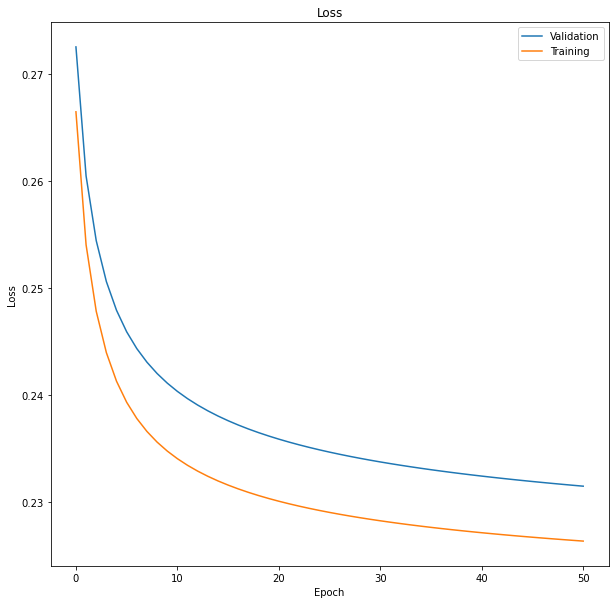

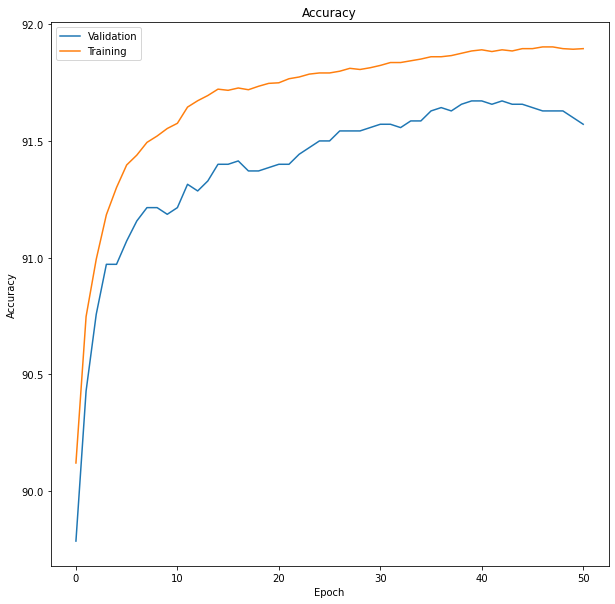

In [105]:
line_plot(data=[model.history['val_loss'], model.history['loss']], legend=['Validation', 'Training'], y_label='Loss')
line_plot(data=[model.history['val_acc'], model.history['acc']], legend=['Validation', 'Training'], y_label='Accuracy')

# RESULTS ON TEST SET

Accuracy on test set: 92.23%
 


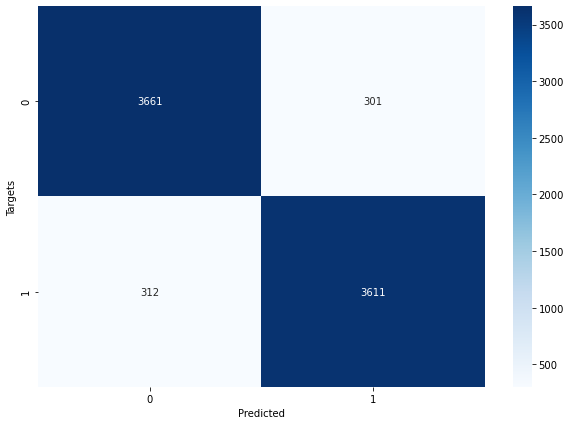

In [106]:
test_predictions = model.predict(X_test)
test_accuracy = model.evaluate(y_test, test_predictions)
print('Accuracy on test set: {0:>2.2f}%'.format(test_accuracy), end='\n \n')

# calculate and plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_true = y_test > 0.5
preds = test_predictions > 0.5
cm = confusion_matrix(y_true, preds)
df_cm = pd.DataFrame(cm, index = [str(i) for i in range(0, 2)],
                  columns = [str(i) for i in range(0, 2)])
fig = plt.figure(figsize = (10,7))
ax = sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')
_ = ax.set_xlabel('Predicted')
_ = ax.set_ylabel('Targets')

## WEIGHTS (COEFFICIENTS) DISTRIBUTION INCLUDING BIAS

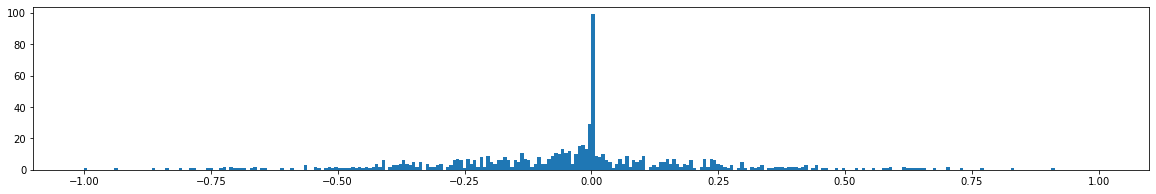

In [107]:
fig = plt.figure(figsize=(20, 3))
_ = plt.hist(model.W.flatten(), bins=300, range=(-1, 1))

# WYBÓR HIPERPARAMETRÓW DO OPTYMALIZACJI

1. LEARNING_RATE: najważniejszy hiperparametr, odnosi się do algorytmu uczenia stochastycznym spadkiem wzdłuż gradientu, odpowiada za wielkość kroku jaki model zrobi w kierunku minimum funkcji kosztu, jeśli jest zbyt duży to uczenie może "przeskoczyć" szukane minimum a jeśli jest zbyt małe to czas w którym zbiegniemy do szukanego minimum jest za długi lub może utknąć w lokalnym minimum.

2. MOMENTUM: współczynnik zaniku, odnosi się do algorytmu uczenia stochastycznym spadkiem wzdłuż gradientu z momentum, w każdym kroku uczenia do macierzy wag dodajemy macierz prędkości która powstała poprzez odjęcie aktualnego gradientu od prędkości z poprzedniego kroku pomnożoną właśnie przez współczynnik zaniku, robimy to po to aby prędkość nie rosła bez ograniczenia.

3. BATCH_SIZE: rozmiar jednej partii przykładów uczących wchodzących do algorytmu uczenia stochastycznym spadkiem wzdłuż gradientu, odpowiada częściowo za to jak szybko model sie uczy oraz za stabiloność uczenia, zazwyczaj przyjmuje wartości z zakresu 8-256, duże wartości mogą znacząco skrócić czas treningu, zwłaszcza przy użyciu akceleratora sprzętowego np. GPU. Mała wartość zwiększy szybkość treningu a poza tym może pomóc w walce z przuczeniem ponieważ każda partia próbek jest zakłoconą reprezentacją całego zbioru więc nasz model nie dostosuje się idealnie do zbioru treningowego i może mieć wiekszą moc generalizacyjną na zbiorze testowym. Zależy też od ilości danych.

4. EPOCHS_COUNT: ilość razy jaką model zostanie trenowany na całym zbiorze danych, najczęściej ustawia się dużą wartość a w trakcie treningu używa mechanizmu wczesnego zatrzymywania, czyli jeśli dokładność modelu na zbiorze walidacyjnym nie poprawi się w kilku kolejnych epochach to kończymy trening modelu (ewentualnie gdy nie spadnie funkcja kosztu) aby zapobiec przeuczeniu.

### Optymalizacja LEARNING_RATE

In [108]:
INPUT_SHAPE = (785, 1)
LEARNING_RATE = 0.1
MOMENTUM = 0.9
BATCH_SIZE = 256
EPOCHS_COUNT = 100
EARLY_STOPPING_ROUNDS = None

loss_history = []
accuracy_history = []
test_accuracy_history = []

learning_rates = [0.002*2**x for x in range(9)]

for learning_rate in learning_rates:
    model = Model(input_shape=INPUT_SHAPE,
              learning_rate=learning_rate,
              momentum=MOMENTUM,
              batch_size=BATCH_SIZE,
              epochs_count=EPOCHS_COUNT,
              loss_function=binary_cross_entropy,
              verbose=False,
              early_stoping_rounds=EARLY_STOPPING_ROUNDS)

    model.fit(X=X_train,
              y=y_train,
              X_val=X_val,
              y_val=y_val)
    
    loss_history.append(model.history['val_loss'])
    accuracy_history.append(model.history['val_acc'])
    
    test_predictions = model.predict(X_test)
    test_accuracy = model.evaluate(y_test, test_predictions)
    test_accuracy_history.append(test_accuracy)

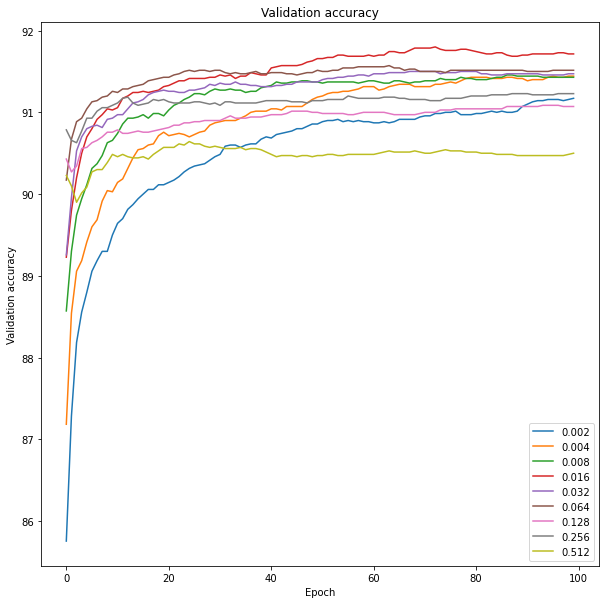

In [109]:
line_plot(data=accuracy_history, legend=[str(x) for x in learning_rates], y_label='Validation accuracy')

Perfekcyjna krzywa nie powinna być zbyt stroma aby nie utkąć w lokalnym minimum i jednocześnie zbyt łagodna aby doszła zbiegła do minumum w skończonym czasie.
- 0.002: zbyt mała wartość, zbiegnięcie do minimum może zająć zbyt wiele czasu
- 0.004: zbyt mała wartość
- 0.008: zbyt mała wartość
- 0.016: optymalna wartość
- 0.032: optymalna wartość
- 0.064: optymalna wartość
- 0.128: zbyt duża wartość, uczenie utknęło w lokalnym minimum
- 0.256: zbyt duża wartość
- 0.512: zbyt duża wartość

In [110]:
pd.DataFrame.from_dict({'learning_rate': learning_rates,
                        'test_accuracy': test_accuracy_history}).sort_values(by='test_accuracy', ascending=False)

,learning_rate,test_accuracy
5,0.064,92.339886
4,0.032,92.238427
3,0.016,92.225745
1,0.004,92.111604
2,0.008,92.111604
0,0.002,92.022828
7,0.256,92.022828
6,0.128,91.731135
8,0.512,91.604312


Różnice pomiędzy dokładnością zbiorze testowym są niewielkie ale częściowo odzwierciedlają dokładności na zbiorze walidacyjnym powyżej.

### Optymalizacja MOMENTUM

Po przeprowadzeniu kilku eksperymentów zauważyłem że parametr MOMENTUM bardzo mocno zależy od LEARNING_RATE dlatego nie ma potrzeby dostosowywać tych 2 parametrów, wystarczy odpowiednio dobrać jeden przy stałej wartości drugiego.

### Optymalizacja BATCH_SIZE bez wczesnego zatrzymywania

In [111]:
INPUT_SHAPE = (785, 1)
LEARNING_RATE = 0.064
MOMENTUM = 0.9
BATCH_SIZE = 256
EPOCHS_COUNT = 150
EARLY_STOPPING_ROUNDS = None

loss_history = []
accuracy_history = []
test_accuracy_history = []

batch_sizes = [16, 32, 64, 128, 256, 512]

for batch_size in batch_sizes:
    model = Model(input_shape=INPUT_SHAPE,
              learning_rate=LEARNING_RATE,
              momentum=MOMENTUM,
              batch_size=batch_size,
              epochs_count=EPOCHS_COUNT,
              loss_function=binary_cross_entropy,
              verbose=False,
              early_stoping_rounds=EARLY_STOPPING_ROUNDS)

    model.fit(X=X_train,
              y=y_train,
              X_val=X_val,
              y_val=y_val)
    
    loss_history.append(model.history['val_loss'])
    accuracy_history.append(model.history['val_acc'])
    
    test_predictions = model.predict(X_test)
    test_accuracy = model.evaluate(y_test, test_predictions)
    test_accuracy_history.append(test_accuracy)

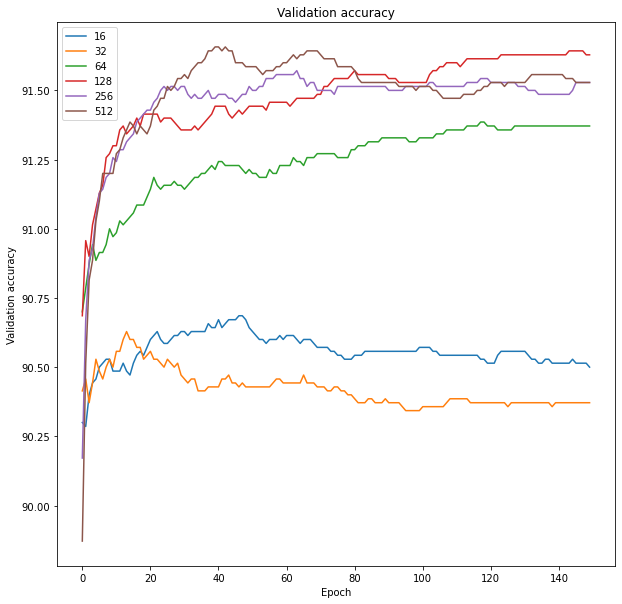

In [112]:
line_plot(data=accuracy_history, legend=[str(x) for x in batch_sizes], y_label='Validation accuracy')

In [113]:
pd.DataFrame.from_dict({'batch_size': batch_sizes,
                        'test_accuracy': test_accuracy_history}).sort_values(by='test_accuracy', ascending=False)

,batch_size,test_accuracy
5,512,92.339886
4,256,92.327204
3,128,92.086240
2,64,91.819911
0,16,91.312619
1,32,90.970197


Możemy łatwo zauważyć rozmiary paczek wynoszące 16 i 32 dają najgorsze wyniki oraz im większy rozmiar tym model szybciej sie uczy oraz osiąga lepszą dokładność na zbiorze testowym.

### Optymalizacja BATCH_SIZE z wczesnym zatrzymywaniem

In [114]:
INPUT_SHAPE = (785, 1)
LEARNING_RATE = 0.064
MOMENTUM = 0.9
BATCH_SIZE = 512
EPOCHS_COUNT = 150
EARLY_STOPPING_ROUNDS = 20

loss_history = []
accuracy_history = []
test_accuracy_history = []

batch_sizes = [16, 32, 64, 128, 256, 512]

for batch_size in batch_sizes:
    model = Model(input_shape=INPUT_SHAPE,
              learning_rate=LEARNING_RATE,
              momentum=MOMENTUM,
              batch_size=batch_size,
              epochs_count=EPOCHS_COUNT,
              loss_function=binary_cross_entropy,
              verbose=False,
              early_stoping_rounds=EARLY_STOPPING_ROUNDS)

    model.fit(X=X_train,
              y=y_train,
              X_val=X_val,
              y_val=y_val)
    
    loss_history.append(model.history['val_loss'])
    accuracy_history.append(model.history['val_acc'])
    
    test_predictions = model.predict(X_test)
    test_accuracy = model.evaluate(y_test, test_predictions)
    test_accuracy_history.append(test_accuracy)

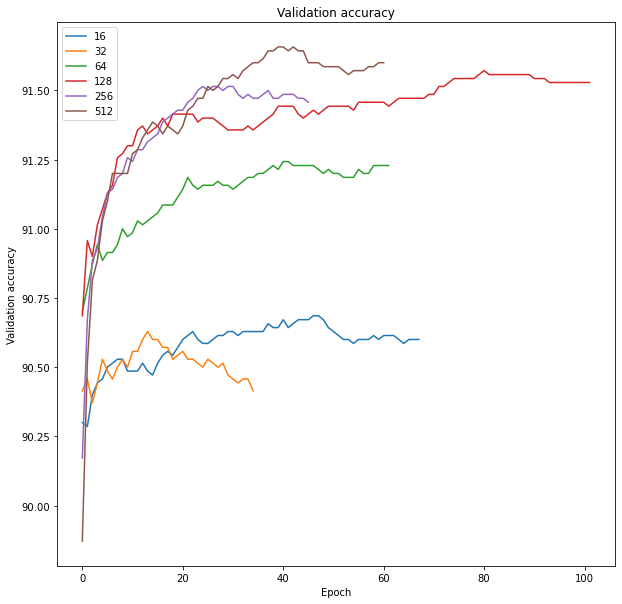

In [115]:
line_plot(data=accuracy_history, legend=[str(x) for x in batch_sizes], y_label='Validation accuracy')

In [116]:
pd.DataFrame.from_dict({'batch_size': batch_sizes,
                        'test_accuracy': test_accuracy_history}).sort_values(by='test_accuracy', ascending=False)

,batch_size,test_accuracy
4,256,92.289157
5,512,92.276474
3,128,92.098922
2,64,91.781864
0,16,91.439442
1,32,91.414077


Można zauważyć że uzyskaliśmy gorsze rezultaty rezultaty dla treningu z wczesnym zatrzymywaniem niż bez ale dalej można zauważyć że większe rozmiary dają model które lepiej generalizuje się do zbioru testowego. 

#### Ostatecznie najwyższa dokładność na zbiorze testowym wynosi 92.34% i została uzyskana dla tych hiperparametrów:
- LEARNING_RATE = 0.06
- MOMENTUM = 0.9
- BATCH_SIZE = 512
- EPOCHS_COUNT = 150
- EARLY_STOPPING_ROUNDS = None